In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import csv
import numpy as np
import SD2_Model as SD

In [3]:

#net = SD.Net()
device = torch.device("cuda") 
net = SD.Net().to(device)
summary(net, input_size = (1,2))
#print(net)

loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 5]              15
            Linear-2                 [-1, 1, 5]              30
            Linear-3                 [-1, 1, 5]              30
            Linear-4                 [-1, 1, 5]              30
            Linear-5                 [-1, 1, 2]              12
Total params: 117
Trainable params: 117
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [4]:
class Coordinates_Dataset(Dataset):
    def __init__(self, datapath):
        #load data
        data = np.loadtxt(datapath ,delimiter=',', dtype=np.float32)
        #feature, data_label = data
        #self.feature = torch.from_numpy(data[:,0:2]).to(device)
        #trying to normailze data
        self.feature = torch.from_numpy(np.concatenate((data[:,0:1]-256,data[:,1:2]-160), axis=1)).to(device)
        self.data_label = torch.from_numpy(data[:,2:4] * 100).to(device) #convert meters to cm
        self.num_samples = data.shape[0]

    def __getitem__(self,index):
        #get data
        #print("index: ",index)
        return self.feature[index],self.data_label[index]


    def __len__(self):
        #len(data)
        return self.num_samples

dataset = Coordinates_Dataset('../Datasets/2NN_all_dataset.csv')
feature, label = dataset[0]
print(feature, label)
trainset = DataLoader(dataset=dataset, batch_size=200, shuffle=True)

tensor([ 0., -7.], device='cuda:0') tensor([3.3252, 1.0083], device='cuda:0')


In [ ]:
## Old data loader
Load_data = False
dataset_path = "../Datasets/2NN_dataset_flight.3.csv"
if(Load_data):
    trainset = []
    with open(dataset_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            #feature, data_label = int(row[0:2]),row[2:4]
            feature, data_label = (int(row[0]),int(row[1])),(float(row[2]) * 100 ,float(row[3]) * 100) #convert to cm
            #feature, data_label = (int(row[0]),int(row[1])),(round(float(row[2]) * 100) ,round(float(row[3]) * 100)) #convert to cm
            trainset.append([feature, data_label])
            #print([feature, data_label])
    trainset = torch.Tensor(trainset).to(device)
    #print(trainset)

test_data = False
if(test_data):
    feature, data_label = trainset[0]
    print(feature, data_label)
    #print(feature.view(1,2))
    output = net(feature)
    print(output)

In [5]:
train = True
train =False
epochs = 100
best_loss = 0.0
if (train):
    net.train()
    for epoch in range(epochs):
        for data in trainset:  
            feature, data_label = data #
            #print(data)
            #print(feature)
            #print(data_label)
            net.zero_grad()  
            output = net(feature)
            loss = loss_function(output, data_label) 
            loss.backward() 
            optimizer.step() 
        print(epoch,loss)

In [6]:
#save network
save = True
save = False
model_save_path = "2nd_NN.pt"
if (save):
    torch.save(net, model_save_path)

In [9]:
#test evaluate

Load_eval = True
if(Load_eval):
    #model = SD.Net().to(device)
    net = torch.load("2nd_NN_looks_good.pt")
    net.eval()

dataset_path = "../Datasets/2NN_dataset_eval_data.csv"
if(True):
    net.eval()
    eval_data = Coordinates_Dataset(dataset_path)
    _, datalabel = eval_data[:]
    datalabel_out = datalabel.cpu().detach().numpy()
    model_output = np.empty((0,2))
    for feature, datalabel in eval_data:
        output = net(feature)
        output_cpu = output.cpu().detach().numpy()
        #datalabel_cpu = datalabel.cpu().detach().numpy()
        #print(output_cpu)
        #print(model_output)
        model_output = np.append(model_output,[output_cpu], axis=0)
    #print(model_output)        
             
        

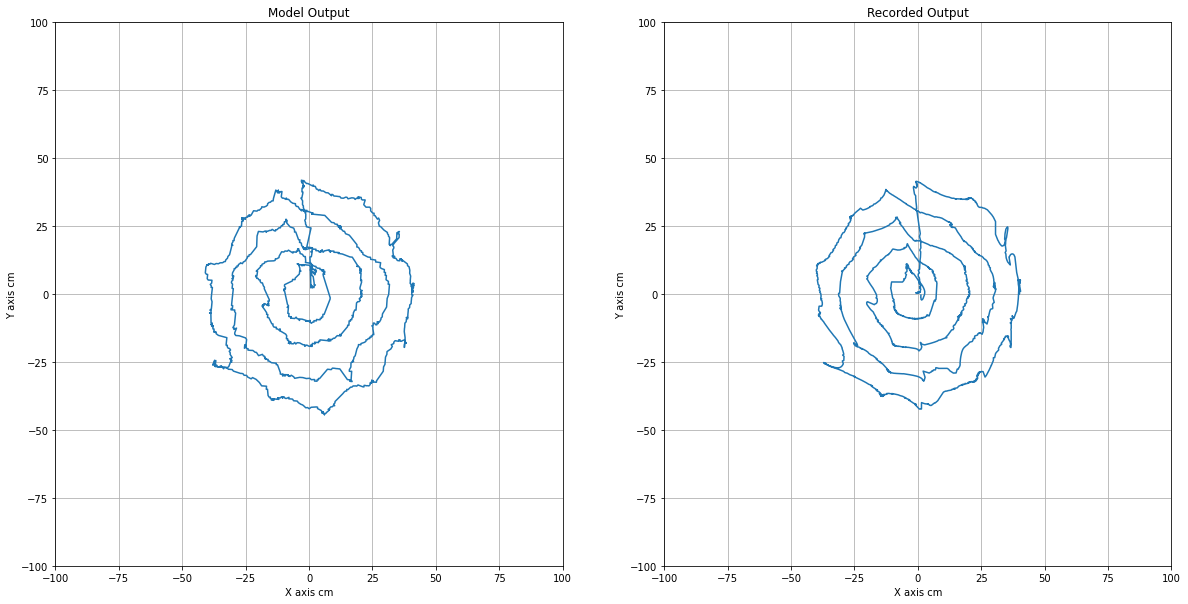

In [12]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(model_output[:,1],model_output[:,0])
ax1.set_xlim([-100, 100])
ax1.set_ylim([-100, 100])
ax1.set_ylabel('Y axis cm')
ax1.set_xlabel('X axis cm')
ax1.set_title('Model Output')
ax1.grid()

ax2.plot(datalabel_out[:,1],datalabel_out[:,0])
ax2.set_xlim([-100, 100])
ax2.set_ylim([-100, 100])
ax2.set_ylabel('Y axis cm')
ax2.set_xlabel('X axis cm')
ax2.set_title('Recorded Output')
ax2.grid()

plt.show()